In [1]:
import yfinance as yf
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.metrics import precision_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.tree import ExtraTreeClassifier
from sklearn import metrics

#  BTC Price Forecasting Model
Author: Mario Malev

# 1. Overview

### What is time series?
Time series data is an ordered set of observations with respect to time periods. In simple words, a sequential organization of data accordingly to their time of occurrence is termed as __time series__. 
##### Some examples of time series data can be:  

Consumption of energy per hour  
Sales on daily basis  
Company's profits per quarter  
Annual changes in a population of a country.

### What is a forecasting model?
Forecasting time series models are Machine Learning algorithms that try to predict the future value of a target variable, given data about it in the past.
##### Some examples of where such models are being used can be: 
Economics:   
Gross Domestic Product (GDP), Consumer Price Index (CPI), and unemployment rates
    
Social sciences:  
Birth rates, population, migration data, political indicators
    
Epidemiology:  
Disease rates, mortality rates, mosquito populations
    
Medicine:  
Blood pressure tracking, weight tracking, cholesterol measurements, heart rate monitoring
    
Physical sciences:  
Global temperatures, monthly sunspot observations, pollution levels

### There are two main methods of approach in the Time-Series Forecasting Models: 
There is the __Univariate Time-series Forecasting__ method and the __Multivariate Time-series Forecasting__ method.

In the __Univariate Time-series Forecasting__ method, forecasting problems contain only two variables in which one is time and the other is the field we are looking to forecast.

On the other hand, in the __Multivariate Time-series Forecasting__ method forecasting problems contain multiple variables keeping one variable as time fixed and others will be multiple in parameters. 

Generally speaking, its a good idea to use the __Univariate Time-series Forecasting__ only when we have stationary data. Stationary here means that the time series data properties such as mean, variance, autocorrelation, etc. are all constant over time to make sure there is no seasonality in our data. This is important because most of the forecasting methods in time series analysis are based on the assumption that the time series can be rendered approximately stationary through the use of mathematical transformations.

<img src = https://d1rwhvwstyk9gu.cloudfront.net/2022/05/Fig.1-Stationary-Time-Series.png
svg.png width = "600" height = "300" align='left'>

### There are a couple types of models we use for Time-series Forecasting
Broadly specified time-series models are Autoregressive (AR), Moving Average(MA) and some other models that are just a combination of these.

__AR (Auto-Regressive) Model__  
The __Auto-Regressive Model__ calculates the regression of past time series(lags) and calculates the present or future values in the series. For example: The Electricity usage today may depend on the usage for the previus time-series periods(lags).

<img src = https://vitalflux.com/wp-content/uploads/2021/03/time-series-forecasting-autoregressive-model.jpg
svg.png width = "500" height = "300" align='left'>

__MA (Moving Avarage) Model__    
A __moving average process__, or the __moving average model__, states that the current value is linearly dependent on the current and past error terms. The error terms are assumed to be mutually independent and normally distributed, just like white noise. The model expresses the present value as a linear combination of the mean of the series, the present error term, and past error terms. The magnitude of the impact of past errors on the present value is quantified using a coefficient. 

<img src = https://miro.medium.com/max/1086/1*zKxqvHiW7zr5XCyMUBG4jA.png
svg.png width = "600" height = "300" align='left'>

####  What is the goal of this project?
##### I am goig to be making a Moving Avarage ML model that forecasts the directon of Bitcoins price moves.
I decided to use a MA model, because of the naturally random nature of the financial markets. I am goint to be using some real world data, combined with a few technical indicators to try and predict where the market is going to go.  

##### Motive and idea
I've been in the financial markets for a year and a half and I've always wanted to build a price prediction model, so I decided to take my ML skills and try to build a model that can predict the price moves of Bitcoin. This is a really difficult task, since there are a lot of different events and factors that can influence the price action of the financial markets. The main goal of this project is to build a model that can predict the direction of tomorrows price move for btc, given a combination of technical and sentimental data. It's really tempting to try and guess the exact price, but such a model requires a really low margin of error in order to be profitable, because even if it can predict the price with a +-5% error, we can still lose money, despite being "right". 

### Scoring
I'm going to be mesuring the model based on its __Presicion score__:  
The precision score is essentialy going to mesure: Out of all the times that we said the price will go up, how many times it actually went up. I want to optimise the model for minimizing the times in which it loses money, if it were to trade without financial instruments like options and futures.

<img src = https://hasty.ai/media/pages/docs/mp-wiki/metrics/precision/3c8be51f15-1653651762/15.png
svg.png width = "600" height = "600" align='left'>

#### Benchmark: 
Since the markets are really unpredictable, its close to impossible to make a model with a really 'high' score. Because of that i want to set the benchmark for this project to be that its better than just being long(betting the price is going to go up) everyday. To mesure that, im going to be using the distribution of the price moves on the given data i.e.:  
If we test our model on X time period and in that time period the price went up Y% of the time, our benchmark score is >Y%.  
If we test our model on Z time period and in that time period the price went up K% of the time, our benchmark score becomes >K%

###### Lets get some things out of the way first
1) We have to keep in mind that financial markets are just glorified horse betting and there is a lot of randomness and noise in the moves.

2) Black swan events have the biggest influence in the moves of the financial markets and predicting such events is outside the realm of this project.

3) There are probably some typos, since half the project was fueled by redbull and on a bit of a time crunch. Sorry in advance!

### Ok, now that we got that out of the way, lets begin

# 2. Data
###### We're going to use these two datasets as our sentiment proxies.
Wikipedia sentiment analysis data from DataQuest: https://github.com/dataquestio/project-walkthroughs/blob/master/bitcoin_price/wikipedia_edits.csv.

This dataset was created by taking data for edits in the wikipedia page of Bitcoin and running the huggingface sentiment analysis model on the description of the edit.

Web scraped twitter data from BitInfoCharts: https://bitinfocharts.com/comparison/bitcoin-tweets.html#alltime. 

This tells us how many tweets about Bitcoin there were every day.

###### And this is going to be our price of btc data
Btc data from YahooFinance via the yfinance python library

In [2]:
#reading the data from local files
tweets = pd.read_csv(r"D:\Projects\Softuni BTC ML Model\tweets.csv",na_values='null')
tweets = tweets.fillna(tweets.n_tweets.mean())
wiki = pd.read_csv(r"D:\Projects\Softuni BTC ML Model\wikipedia_edits.csv")

#getting the BTC price data from the yfinance library
btc = yf.Ticker('BTC-USD')
btc = btc.history(period='max')
btc.index = btc.index.strftime('%Y-%m-%d')
btc = btc.drop(columns = ['Dividends','Stock Splits'])
btc.index.names = ['date']

#formating the data
tweets.columns=['date','n_tweets']
tweets['date'] = pd.to_datetime(tweets['date'])
wiki['date'] = pd.to_datetime(wiki['date'])
btc.index = pd.to_datetime(btc.index)

#constructing the final dataset
btc=btc.merge(wiki, on='date', how='left').merge(tweets, on='date', how='left').dropna()
btc.columns = ['date','open', 'high', 'low', 'close', 'Volume', 'edit_count', 'sentiment', 'neg_sentiment', 'n_tweets']



We have to make a couple more columns for our targets and we ca start exploring our data. We're going to be making a column for tomorrows price of Bitcoin and our target column, which is going to mesure the direction of tomoorows price move.


In [3]:
#making a column for the price of btc tomorrow
btc['price_tmr'] = btc['close'].shift(-1)
#making a target column for the price move, such that Price up = 1, Price down = 0
btc['direction_tmr']=(btc['price_tmr']>btc['close']).astype(int)
#setting the date as index
btc = btc.set_index(btc['date'])
btc = btc.drop(columns=['date'])

btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,direction_tmr
date,,,,,,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,21056800,5.03,-0.23,0.53,27946.00,424.44,0
2014-09-18,456.86,456.86,413.10,424.44,34483200,5.07,-0.23,0.53,21135.00,394.80,0
2014-09-19,424.10,427.83,384.53,394.80,37919700,5.20,-0.24,0.55,20775.00,408.90,1
2014-09-20,394.67,423.30,389.88,408.90,36863600,5.20,-0.23,0.55,17607.00,398.82,0
2014-09-21,408.08,412.43,393.18,398.82,26580100,5.23,-0.20,0.53,17026.00,402.15,1


# 3. Exloratory Data Analysis

##### First, lets check the distribution of the days that the price went up and the days that the pice went down.

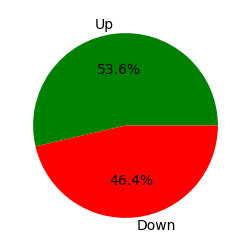

In [4]:
#ploting a pie chart on the target value
plt.figure(figsize=(3, 3))
pie=plt.pie(btc['direction_tmr'].value_counts(),autopct='%1.1f%%', labels=['Up','Down'], colors=('green', 'red'))
plt.show()

###### Insights: 
The number of green and red days are really balanced out. 

If we were to buy at the start of every day and sell at the end of every day, we would've been in profit 53.6% of the time. In order for the model to have any predictive power it needs to have a prescision score of at least 54%.Thats also the score that the modelfrom DataQuest's project managed to achieve, so if we can beat that im going to consider it a succesfull project.  

#### Next lets plot a correlation heatmap and see if we can find any interesting correlations in our dataframe


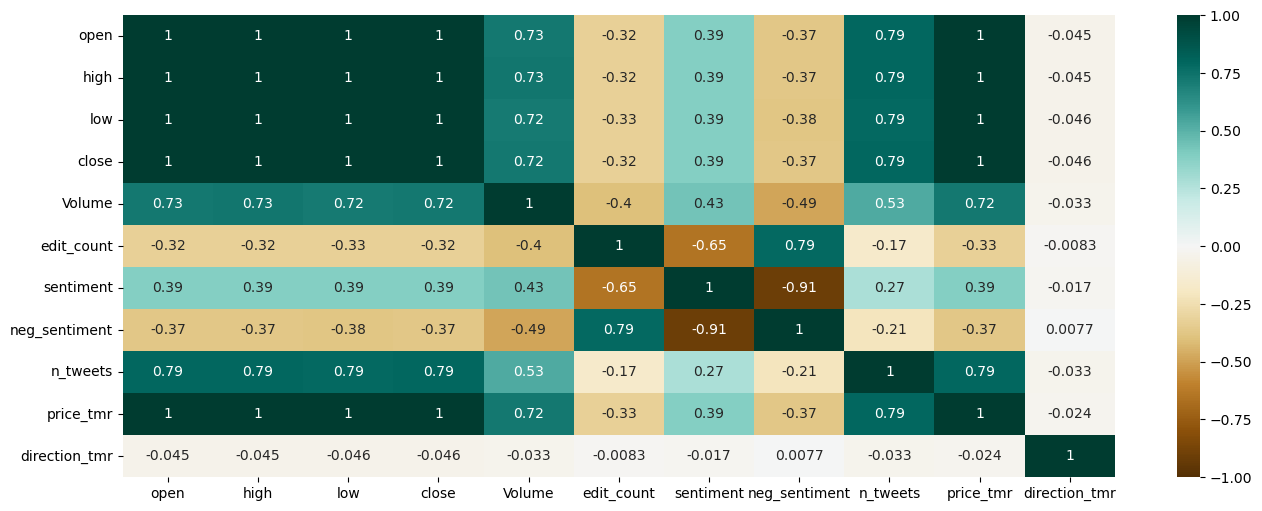

In [5]:
#ploting a correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(btc.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

###### Insights:
There are practically no correlations between the direction of the market and any features, which is to be expected since the data hasn't been fully proccesed yet.
There are some correlations which caught my attention though:

##### 1)  The number of tweets per day highly correlates with the price of BTC. This can be explained by that the more intrest there is in BTC, the more pepole are possible investors.(check plot below)

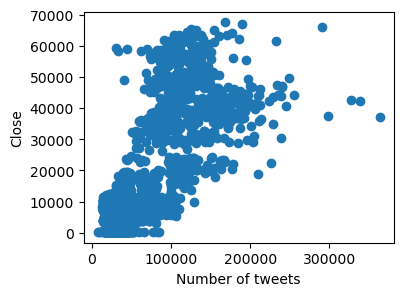

In [6]:
#plotting a scatter plot
plt.figure(figsize=(4,3))
plt.scatter(btc.n_tweets, btc.close)
plt.xlabel('Number of tweets')
plt.ylabel('Close')
plt.show()


##### 2) The negative sentiment of the wikipedia edits highly correlates with the number of edits. This leads me to belive that pepole react to the negative price moves far more than the positive. We can see that the number of edits grow exponentially as the negative sentiment rises (check plot below).



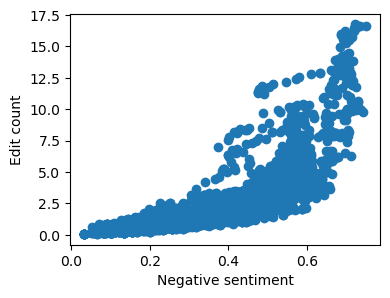

In [7]:
#plotting a scatter plot
plt.figure(figsize=(4,3))
plt.scatter(btc.neg_sentiment, btc.edit_count)
plt.xlabel('Negative sentiment')
plt.ylabel('Edit count')
plt.show()

###### Next I want to check the data for seasonality
From my expirience in the market ive noticed that the price usually goes up on mondays and tuesdays and usually dumps on fridays, but lets see if this is a real thing.
First I'm going to try and see if there is any seasonality, then I want to check each day of the week.

##### I'm going to be using the Chi squared metric to mesure the autocorrelation on the different timeframes.
The Chi squared metric is used to mesure correlation between two binary arrays. It tells us the difference between the real value and the expected value, so the lower the score is the more correlation there is.
The formula for the Chi-Squared test is the following: 


<img src = https://cdn1.byjus.com/wp-content/uploads/2020/10/Chi-Square-Test.png
svg.png width = "500" height = "300" align='left'>


In [8]:
horizons = (1,3,7,14,30,365)
for horizon in horizons:
    crosstab = pd.crosstab(index=btc['direction_tmr'], columns=[btc['direction_tmr'].shift(horizon)])
    ChiSqResult = chi2_contingency(crosstab)
    print('The P-Value of the ChiSq Test for', horizon, 'days is:', ChiSqResult[1])

The P-Value of the ChiSq Test for 1 days is: 0.008829783243023937
The P-Value of the ChiSq Test for 3 days is: 0.20807360560065777
The P-Value of the ChiSq Test for 7 days is: 0.12907462752297533
The P-Value of the ChiSq Test for 14 days is: 0.3912561256785062
The P-Value of the ChiSq Test for 30 days is: 0.972775417378184
The P-Value of the ChiSq Test for 365 days is: 0.10809594095905409


###### Insight
I can see that there is correlation between todays price move and tomorrows price move, which can suggest that the price usually moves in swings.

##### Next im going to check the correlation between the price moves and the day of the week.

In [9]:
btc['date'] = btc.index
btc['day_of_week'] = btc['date'].dt.day_name()

day_of_week = btc[['day_of_week', 'direction_tmr']]
day_of_week = pd.get_dummies(day_of_week)

btc = btc.drop(columns=['day_of_week','date'])

for column in day_of_week.drop(columns='direction_tmr'):
    crosstab = pd.crosstab(index=btc['direction_tmr'], columns=[day_of_week[f'{column}'].shift(horizon)])
    ChiSqResult = chi2_contingency(crosstab)
    print('The P-Value of the ChiSq Test for', column, 'is:', ChiSqResult[1])

The P-Value of the ChiSq Test for day_of_week_Friday is: 0.3551265639457982
The P-Value of the ChiSq Test for day_of_week_Monday is: 0.9218475309951418
The P-Value of the ChiSq Test for day_of_week_Saturday is: 0.9876033920197412
The P-Value of the ChiSq Test for day_of_week_Sunday is: 0.5593827730841352
The P-Value of the ChiSq Test for day_of_week_Thursday is: 0.11514533605700318
The P-Value of the ChiSq Test for day_of_week_Tuesday is: 0.5593827730841352
The P-Value of the ChiSq Test for day_of_week_Wednesday is: 0.6238375985034201


###### Insight
There are no meaningfull correlations between the day of the week and the price action, exept for Thursdays.

<Figure size 100x100 with 0 Axes>

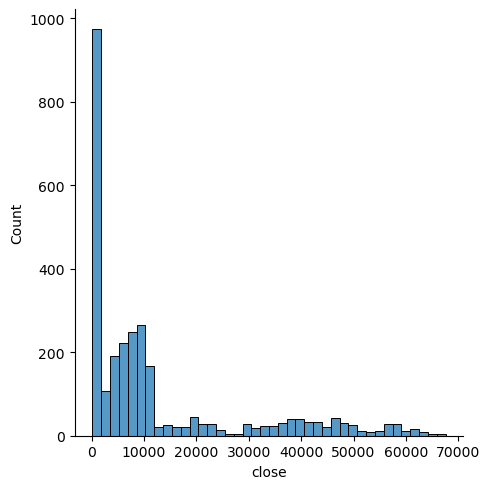

<Figure size 100x100 with 0 Axes>

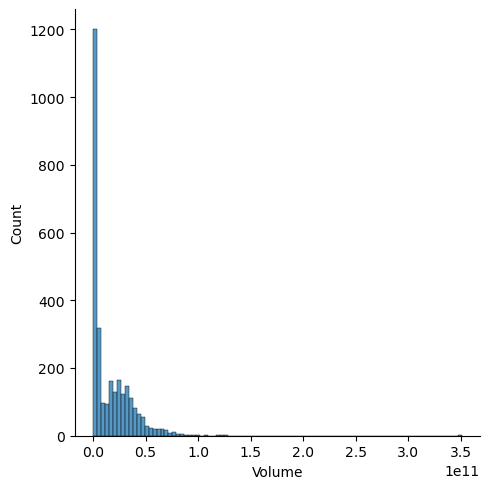

<Figure size 100x100 with 0 Axes>

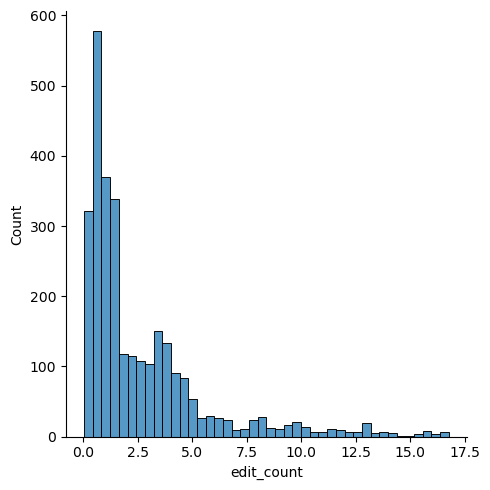

<Figure size 100x100 with 0 Axes>

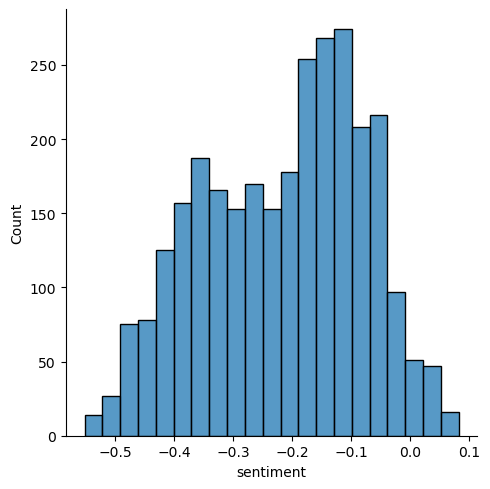

<Figure size 100x100 with 0 Axes>

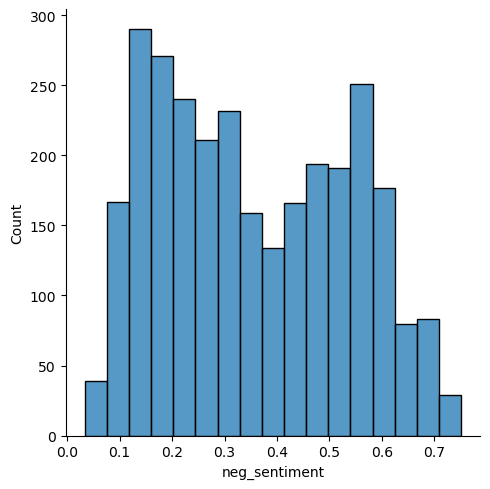

<Figure size 100x100 with 0 Axes>

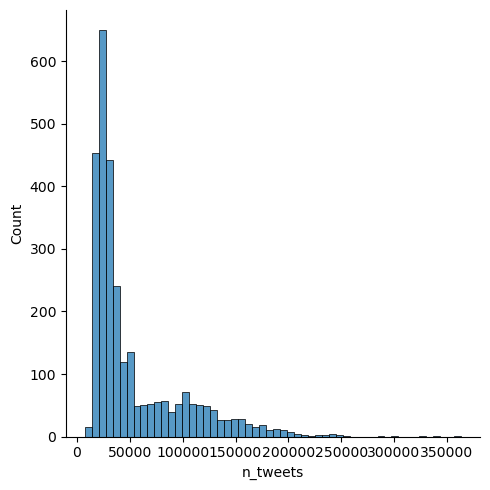

In [10]:
for_plot = btc[['close','Volume','edit_count','sentiment','neg_sentiment','n_tweets']]
for x in for_plot:
    plt.figure(figsize=(1,1))
    sns.displot(btc[f'{x}'])
    plt.show()

We can see that most of the data is heavily skewed to the right, which is to be expected, since most of the data has a hard stop of 0 on the left. We can see that the sentiment data is more evenly distributed, although still skewed a little to the left and to the right respectfully.

# 4. Feature engeneering

Since our algorithms have no conception of time we have to help them out a little bit. We have to do some feature engeneering and make features that take into account the time series nature of our data.

#### First im going to make rolling avarages for all the features.

In [11]:
def compute_rolling(btc):
    horizons=(2,7,60,365)

    for horizon in horizons:
        #making rolling avarages for the dataframe
        rolling_avarages = btc.rolling(horizon, min_periods=1).mean()
        
        #making a column for the ratio between the price today and the rolling avarage
        ratio_column = f"close_ratio{horizon}"
        btc[ratio_column] = btc['close']/rolling_avarages['close']
        
        #rolling avarage for the number of edits
        edit_column = f"edit_{horizon}"
        btc[edit_column] = rolling_avarages['edit_count']
        
        #rolling avarage for the number of tweets
        n_tweets_column = f"n_tweets_{horizon}"
        btc[n_tweets_column] = rolling_avarages['n_tweets']
        
        #making a column for the trend of the price moves
        rolling = btc.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend{horizon}"
        btc[trend_column] = rolling['direction_tmr']
        
    return btc 

In [12]:
compute_rolling(btc)

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,n_tweets_7,trend7,close_ratio60,edit_60,n_tweets_60,trend60,close_ratio365,edit_365,n_tweets_365,trend365
date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.86,468.17,452.42,457.33,21056800,5.03,-0.23,0.53,27946.00,424.44,...,27946.00,NaN,1.00,5.03,27946.00,NaN,1.00,5.03,27946.00,NaN
2014-09-18,456.86,456.86,413.10,424.44,34483200,5.07,-0.23,0.53,21135.00,394.80,...,24540.50,0.00,0.96,5.05,24540.50,0.00,0.96,5.05,24540.50,0.00
2014-09-19,424.10,427.83,384.53,394.80,37919700,5.20,-0.24,0.55,20775.00,408.90,...,23285.33,0.00,0.93,5.10,23285.33,0.00,0.93,5.10,23285.33,0.00
2014-09-20,394.67,423.30,389.88,408.90,36863600,5.20,-0.23,0.55,17607.00,398.82,...,21865.75,0.33,0.97,5.12,21865.75,0.33,0.97,5.12,21865.75,0.33
2014-09-21,408.08,412.43,393.18,398.82,26580100,5.23,-0.20,0.53,17026.00,402.15,...,20897.80,0.25,0.96,5.15,20897.80,0.25,0.96,5.15,20897.80,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-04,19832.47,19999.69,19636.82,19986.71,25245861652,0.40,-0.11,0.15,83846.00,19812.37,...,101425.00,0.57,0.91,0.27,117487.70,0.43,0.51,0.89,142978.79,0.48
2022-09-05,19988.79,20031.16,19673.05,19812.37,28813460025,0.40,-0.11,0.15,99478.00,18837.67,...,99091.86,0.43,0.90,0.27,116718.23,0.42,0.50,0.89,143001.88,0.48
2022-09-06,19817.72,20155.27,18800.17,18837.67,43403978910,0.43,-0.08,0.15,111495.00,19290.32,...,100339.14,0.43,0.86,0.26,116562.45,0.40,0.48,0.89,142929.91,0.48


###### Next im making a rsi indicator for the close price
The Relative Strenght Index is a well known metric that has been proven to work, and i've personally found really usefull in my exprience. Iu essentially mesures the ratio between the avarage gain vs the avarage loss of the market in the selected time period and tells us how overbought or oversold an asset is.

The formula for calculating the RSI index is the following:

<img src = https://www.alpharithms.com/wp-content/uploads/1674/rsi-formulae-alpharithms-1600x900.jpg
svg.png width = "300" height = "300" align='left'>


Now let's make it into a feature

In [13]:
def compute_rsi(btc):
    horizons=(6,12,24)
    
    for horizon in horizons:
        # to calculate RSI, we first need to calculate the exponential weighted aveage gain and loss during the period
        gain = (btc['close'] - btc['open']).apply(lambda x: x if x > 0 else 0)
        loss = (btc['close'] - btc['open']).apply(lambda x: -x if x < 0 else 0)

        # here we use the same formula to calculate Exponential Moving Average
        ema_gain = gain.ewm(span=horizon, min_periods=horizon).mean()
        ema_loss = loss.ewm(span=horizon, min_periods=horizon).mean()

        # the Relative Strength is the ratio between the exponential avg gain divided by the exponential avg loss
        rs = ema_gain / ema_loss

        # the RSI is calculated based on the Relative Strength using the following formula
        rsi_column = 100 - (100 / (rs + 1))
        btc[f"rsi{horizon}"] = rsi_column   
        
    return btc



In [14]:
compute_rsi(btc)
btc = btc.dropna()
btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,edit_60,n_tweets_60,trend60,close_ratio365,edit_365,n_tweets_365,trend365,rsi6,rsi12,rsi24
date,,,,,,,,,,,,,,,,,,,,,
2014-10-10,364.69,375.07,352.96,361.56,43665700,5.13,-0.25,0.51,19090.00,362.30,...,4.85,20380.25,0.35,0.94,4.85,20380.25,0.35,65.48,50.57,41.46
2014-10-11,361.36,367.19,355.95,362.30,13345200,5.37,-0.27,0.54,17107.00,378.55,...,4.87,20249.32,0.38,0.95,4.87,20249.32,0.38,66.75,51.34,41.92
2014-10-12,362.61,379.43,356.14,378.55,17552800,5.37,-0.27,0.54,17072.00,390.41,...,4.89,20127.12,0.40,0.99,4.89,20127.12,0.40,82.30,62.92,49.32
2014-10-13,377.92,397.23,368.90,390.41,35221400,5.90,-0.27,0.54,22018.00,400.87,...,4.93,20197.15,0.42,1.02,4.93,20197.15,0.42,88.30,69.62,54.28
2014-10-14,391.69,411.70,391.32,400.87,38491500,6.47,-0.25,0.53,25804.00,394.77,...,4.98,20397.39,0.44,1.04,4.98,20397.39,0.44,91.33,73.74,57.59


#### Lets see it in action
We can see that the rsi is a great indicator and can predict local tops and bottoms really well. Its not perfect, but it can give us a goot estimation of how much Bitcoin is overbought(price is too high) or oversold(price is too low). The higher the value of the index, the more likeley the price is to go down and vice-versa.

(__check plot below__)

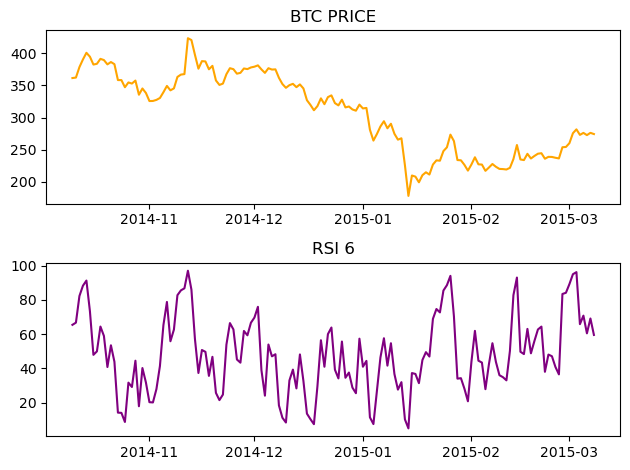

In [15]:
#making a dataframe to test 
for_rsi_plot_6 = btc.iloc[:150]

#making two subplots
fig, axs = plt.subplots(2)

#plotting our charts
axs[0].plot(for_rsi_plot_6.index, for_rsi_plot_6.close, color = 'orange')
axs[0].set_title('BTC PRICE')
axs[1].plot(for_rsi_plot_6.index, for_rsi_plot_6.rsi6, color = 'purple')
axs[1].set_title('RSI 6')
fig.tight_layout()

plt.show()

##### Percent change
Since the market is heavily affected by the emotions of the traders, we have to give some context on the magnitude and rate of the changes of our features, thats why im making some features for the percent change of the close, n_tweets, edit_count and Volume columns.

In [16]:
#defining the function and the time horizons
def percent_change(btc):
    horizons=(1,3,7)
    
#making columns for the percent change of the features    
    for horizon in horizons:
        btc[f'price_change_{horizon}'] = ((btc['close'] - btc['close'].shift(horizon)) / btc['close'].shift(horizon)) * 100
        btc[f'tweets_change_{horizon}'] = ((btc['n_tweets'] - btc['n_tweets'].shift(horizon)) / btc['n_tweets'].shift(horizon)) * 100
        btc[f'edit_count_change_{horizon}'] = ((btc['edit_count'] - btc['edit_count'].shift(horizon)) / btc['edit_count'].shift(horizon)) * 100
        btc[f'volume_change_{horizon}'] = ((btc['Volume'] - btc['Volume'].shift(horizon)) / btc['Volume'].shift(horizon)) * 100
        
    return btc

In [17]:
btc = percent_change(btc.copy())
btc = btc.dropna()
btc.head()

,open,high,low,close,Volume,edit_count,sentiment,neg_sentiment,n_tweets,price_tmr,...,edit_count_change_1,volume_change_1,price_change_3,tweets_change_3,edit_count_change_3,volume_change_3,price_change_7,tweets_change_7,edit_count_change_7,volume_change_7
date,,,,,,,,,,,,,,,,,,,,,
2014-10-17,382.76,385.48,375.39,383.76,13600700,8.27,-0.29,0.56,21491.00,391.44,...,4.20,-49.61,-4.27,-16.71,27.84,-64.67,6.14,12.58,61.04,-68.85
2014-10-18,383.98,395.16,378.97,391.44,11416800,8.20,-0.26,0.53,20572.00,389.55,...,-0.81,-16.06,-0.84,-14.25,15.49,-54.82,8.04,20.25,52.80,-14.45
2014-10-19,391.25,393.94,386.46,389.55,5914570,8.53,-0.29,0.55,18259.00,382.85,...,4.07,-48.19,1.83,-25.31,7.56,-78.09,2.91,6.95,59.01,-66.30
2014-10-20,389.23,390.08,378.25,382.85,16419000,8.90,-0.30,0.56,23312.00,386.48,...,4.30,177.60,-0.24,8.47,7.66,20.72,-1.94,5.88,50.85,-53.38
2014-10-21,382.42,392.65,380.83,386.48,14188900,8.97,-0.30,0.56,22499.00,383.16,...,0.75,-13.58,-1.27,9.37,9.35,24.28,-3.59,-12.81,38.66,-63.14


#### Now i want to check the structure of the price moves
When we plot the daily percentage moves we can see that the price moves are really random and the chart almost resembles a random noise chart. There are some outliers, like the 38% covid crash in 2020. 
The mean price move is +0.2%.

(__check visualization below__)

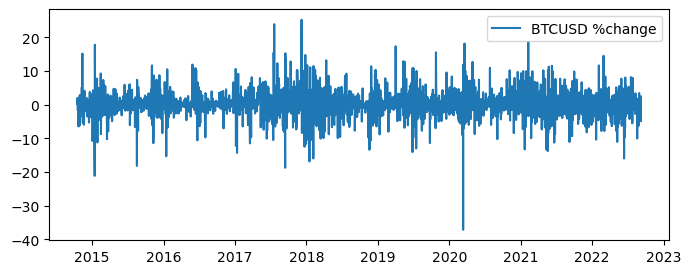

Mean daily move: 0.21145851798516813


In [18]:
#setting the dimentions of figure
plt.figure(figsize=(8,3))

#plotting figure
plt.plot(btc.index, btc['price_change_1'], label = 'BTCUSD %change')
plt.legend()
plt.show()

#getting the mean daily return
print('Mean daily move:', btc.price_change_1.mean())

##### Next, i want to see how the interest in bitcoin changes with its volatolity
We can see that generally the intrest in btc grows as the volitility rises, so a bigger change in tweets might now always lead to a positive price move.
This can be explained by that the bigger price moves bring out more emotions in investors, which in turn results in more activity.

(__check visualization below__)

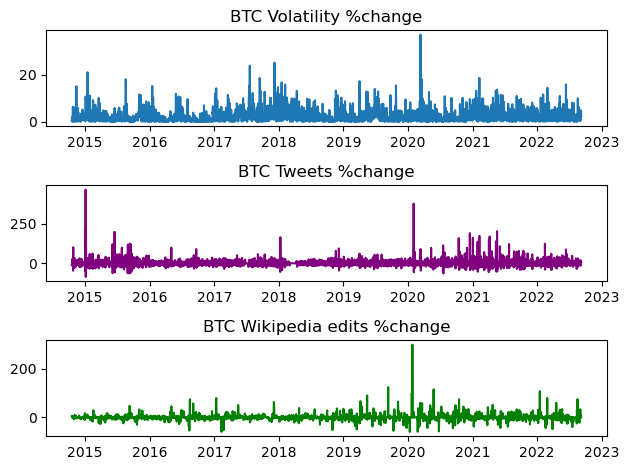

In [19]:
#making three subplots
fig, axs = plt.subplots(3)

#plotting our charts
axs[0].plot(btc.index, btc.price_change_1.abs())
axs[0].set_title('BTC Volatility %change')
axs[1].plot(btc.index, btc.tweets_change_1, color='purple')
axs[1].set_title('BTC Tweets %change')
axs[2].plot(btc.index, btc.edit_count_change_1, color='green')
axs[2].set_title('BTC Wikipedia edits %change')
fig.tight_layout()


plt.show()

#### Next im going to be making columns for the price move of the current date and the same day last week, plus the day of the week

In [20]:
#making a columns for the price move of today and the same day last week
btc['direction_today'] = btc['direction_tmr'].shift(1)
btc['direction_last_week'] = btc['direction_tmr'].shift(7)

#making columns for the Thursday and Friday days
btc['is_thursday'] = day_of_week['day_of_week_Thursday']
btc['is_friday'] = day_of_week['day_of_week_Friday']

##### Now lets see the distribution on the Fridays and Thursdays
We can see that the price of Bitcoin goes up on 56.7% of the time on Fridays and 56.3% of the time on Thursdays which is slightly more than it does on avarage.

So it turns out my thesis that the price usually goes down on fridays is actually false... i dont really know how to feel about this.

(__check visualization below__)

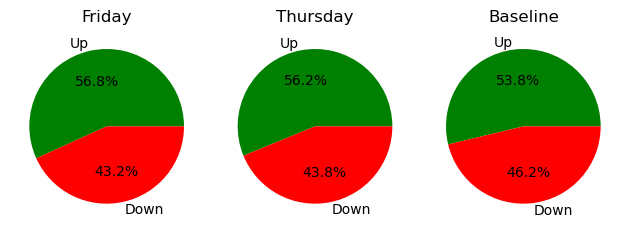

In [21]:
#Making three subfigures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

#making a pie chart for the distribution on Fridays
ax1.pie(btc['direction_tmr'].where(btc['is_friday']==1).value_counts(),autopct='%1.1f%%', labels=['Up','Down'], colors=('green','red'))
ax1.set_title('Friday')

#making a pie chart for the distribution on Thursdays
ax2.pie(btc['direction_tmr'].where(btc['is_thursday']==1).value_counts(),autopct='%1.1f%%', labels=['Up','Down'], colors=('green','red'))
ax2.set_title('Thursday')

#making a pie chart for the distribution of the whole dataset
ax3.pie(btc['direction_tmr'].value_counts(),autopct='%1.1f%%', labels=['Up','Down'], colors=('green','red'))
ax3.set_title('Baseline')

fig.tight_layout()
plt.show()

# 5. Model selection
There are a lot of models we can choose from, so i want to be sure that im making the best possible desicion. Thats why I'm going to be using the LazyPredict library to select the 3 best models for the task.
LazyPredict is going to fit 29 differnt Machine Learning models and give us their scores.

In [22]:
btc = btc.dropna()

#splitting our data into features and target
btc_target = btc['direction_tmr']
btc_features = btc.drop(columns=['direction_tmr','price_tmr'])

#splitting our data into a training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(btc_features, btc_target, shuffle=False, train_size=0.7)

#fitting LazyPredict to our data and adding a precision score as a custom metric
lazy = LazyClassifier(verbose=0 ,ignore_warnings = True, custom_metric=precision_score)
models,pred = lazy.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:08<00:00,  3.32it/s]


In [23]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,precision_score,Time Taken
Model,,,,,,
ExtraTreeClassifier,0.54,0.54,0.54,0.54,0.56,0.03
ExtraTreesClassifier,0.52,0.54,0.54,0.48,0.61,0.48
BernoulliNB,0.51,0.51,0.51,0.50,0.54,0.02
XGBClassifier,0.49,0.51,0.51,0.42,0.57,0.98
LabelSpreading,0.49,0.51,0.51,0.41,0.56,0.55
LabelPropagation,0.49,0.51,0.51,0.41,0.56,0.48
KNeighborsClassifier,0.50,0.51,0.51,0.47,0.54,0.09
AdaBoostClassifier,0.49,0.51,0.51,0.40,0.57,0.55
RandomForestClassifier,0.49,0.51,0.51,0.41,0.56,0.98


We can see that the best preforming models are some form of a Tree or Forest. We can see that the most effective models are the ones that implement a bit of randomness into them. That can be explained by the random and unpredictable nature of our data.
For this model I decided to pick the ExtraTreeClassifier, ExtraTreesClassifier and the XGBClassifier, because they have a high precsision score and are similar in the methods that they use.

##### Next, I'm going to fit a baseline model for each of the calssifiers and see how they perform.
I'm going to be making baseline models for all of the classifiers and giving them a random state of 1, so I know I'm optimizing the same exact model. When the time for testing comes, I will remove the random state, so we can properly test the models.

In [24]:
#making the classifiers
e_trees = ExtraTreesClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
e_tree = ExtraTreeClassifier(random_state=1)

models = [e_trees, xgb, e_tree]

#making a for loop that fits every classifier on the train and test datasets and prints their classification reports
for model in models:
    model.fit(x_train, y_train)
    print(classification_report(y_test,model.predict(x_test)))   

              precision    recall  f1-score   support

           0       0.48      0.89      0.62       411
           1       0.54      0.12      0.20       452

    accuracy                           0.49       863
   macro avg       0.51      0.50      0.41       863
weighted avg       0.51      0.49      0.40       863

              precision    recall  f1-score   support

           0       0.48      0.88      0.62       411
           1       0.57      0.15      0.23       452

    accuracy                           0.49       863
   macro avg       0.53      0.51      0.43       863
weighted avg       0.53      0.49      0.42       863

              precision    recall  f1-score   support

           0       0.49      0.46      0.47       411
           1       0.53      0.56      0.55       452

    accuracy                           0.51       863
   macro avg       0.51      0.51      0.51       863
weighted avg       0.51      0.51      0.51       863



# 6. Making functions

Next, I'm goint to make some functions that are going to come in handy when we're training the models.

I decided to use a RFECV feature selection model, with TimeSeriesSplit as a cv parameter, because I want to have a different set of features for all of the models.

RFE works by fitting a model to the data and removing the features with the lowest importance on every iteration untill it reaches a desired outcome. Im fitting it to every model with the TimeSeriesSplit as a parameter. 

The TimeSeriesSplit works by starting from the first date of the dataset and using the 1st validation set to fit the first model. On the second iteration it fits the model to the data from the previus validation set plus the data from the new validation set. 

I decided to go with 10 validation sets, because the models we're using here have a tendancy to overfit a lot.

<img src = https://www.researchgate.net/publication/342561005/figure/fig2/AS:1084255815897173@1635518139867/Cross-validation-time-series-split.jpg
svg.png width = "500" height = "200" align='left'>


I'm going to make a confusion matrix, a ROC curve and a presicion-recall curve  to track the performance of all the models and visualize where each of them makes mistakes. The confusion matrix tells is how many true positives, true negatives, false positives and false negatives there are. 

The ROC curve tells us two basic evaluation measures – specificity and sensitivity. Specificity is a performance measure of the whole negative part of a dataset, whereas sensitivity is a performance measure of the whole positive part. Generally speaking, the higher and to the left the curve is, the better the model is.

The presicion-recall curve tells us the trade-off between our recall and prescision scores(how much recall we're sacrificing for presicion and vice-versa). Generally speaking the bigger the AOC is, the 'better' the model is. 

We're not going to be normalizing the data, because descision trees are not very sensitive to non normalized/scaled data, but i decided to scale the data, because i find it to be a good practice :)

<img src = https://algolytics.com/wp-content/uploads/2018/05/roc1_en.png
svg.png width = "600" height = "600" align='left'>


In [25]:
#making the validation sets
tsp = TimeSeriesSplit(n_splits=10)

#making a function that fits a feature selector to a model
def make_feature_selector(x, y, model): 

    #fitting the RFECV to the model with the validation data    
    feature_selector = RFECV(model, cv=tsp).fit(x, y)
    return feature_selector 

#making a preprocessing function
def preprocessor(x):
    #making a copy of the dataset
    x_new = x.copy()
    
    #fitting a MinMaxScaler to the data
    x_new = MinMaxScaler().fit_transform(x_new) 
    return x_new

#making the function as a transformer
preprocess_transformer = FunctionTransformer(preprocessor)

#making a function to test the models
def fit_and_print(model, x_train, y_train, x_test, y_test):
    
    #fitting the model and getting predictions
    model.fit(x_train, y_train)
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    
    #making a classification report for the training data
    print('Training score:')
    print(classification_report(y_train, train_preds))
    
    #making a classification report for the testing data
    print('Test score:')
    print(classification_report(y_test, test_preds))
    
    #making a confusion matrix for the test predictions
    sns.heatmap(confusion_matrix(y_test,test_preds),annot=True, cmap='BrBG', fmt='g')
    plt.show()
    
    #making a roc curve
    #getting the false positive rate and true positive rate
    proba = model.predict_proba(x_test)[::, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    
    #plotting the ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate(sensitivity)')
    plt.xlabel('False Positive Rate(1-specificity)')
    plt.show()
    
    
    #making a prescision recalll cuve
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba)
    
    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    plt.show()
    
    
    print('Score:',precision_score(y_test, test_preds))

# 7. Extra Trees
Lets start fitting our models

The Extra Trees model is similar to a RandomForest. A RandomForest fits a tree to a subset of the data and then adds all of the predictions together. The ExtraTrees model is different in the way that is seperates the trees. Instead of choosing the best possible threshold for each tree at each node, it simply chooses a random threshold too.

<img src = https://www.researchgate.net/profile/Navoneel-Chakrabarty/publication/341967355/figure/fig1/AS:901875410948097@1592035262515/Visual-Representation-of-Extra-Trees-Classifier.ppm
svg.png width = "500" height = "500" align='left'>


In [26]:
#fitting the feature selector
feature_selector_e_trees = make_feature_selector(x_train, y_train, e_trees)

#making the new datasets
new_x_train_trees = feature_selector_e_trees.transform(x_train)
new_x_test_trees = feature_selector_e_trees.transform(x_test)

#getting the new features
features = np.array(btc_features.columns)
print(f"Selected features:")
print(features[feature_selector_e_trees.support_])
    

Selected features:
['low' 'rsi6' 'rsi24' 'price_change_1' 'tweets_change_1' 'tweets_change_3'
 'volume_change_3' 'tweets_change_7' 'edit_count_change_7'
 'volume_change_7']


Out of all the features (44), the Extra Trees model selected only 10, the most prevelant being the percent change of the features. The model did not find the rolling avarages information usefull. 

Lets fit a Grid Search and try to optimize the model. I decided to go with the Grid search approach, because of the freedom it gives me to try the specific values that i want to try out. 

My thesis is that since the model tends to overfit a lot, its going to perform better with a greater number of estimators, thats why im trying more values on the greater side.

In [27]:
#making a pipeline that scales the data and fits the model
p1 = Pipeline([('Scaler', preprocess_transformer),('model',e_trees)])

#setting the parameter grid
params = {'model__n_estimators':[70,100,200,400,600],
         'model__min_samples_split':[2,3,5,7],
          'model__min_samples_leaf':[2,3,5]
         }

#making and fitting a grid search
grid_search = GridSearchCV(estimator=p1, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_trees, y_train)

grid_search.best_params_

{'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

Training score:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       917
           1       1.00      1.00      1.00      1096

    accuracy                           1.00      2013
   macro avg       1.00      1.00      1.00      2013
weighted avg       1.00      1.00      1.00      2013

Test score:
              precision    recall  f1-score   support

           0       0.57      0.31      0.40       411
           1       0.56      0.79      0.65       452

    accuracy                           0.56       863
   macro avg       0.56      0.55      0.53       863
weighted avg       0.56      0.56      0.53       863



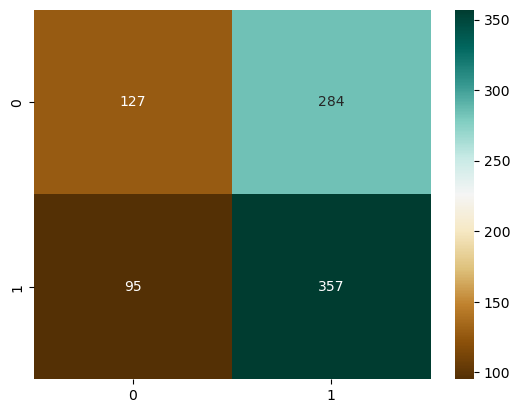

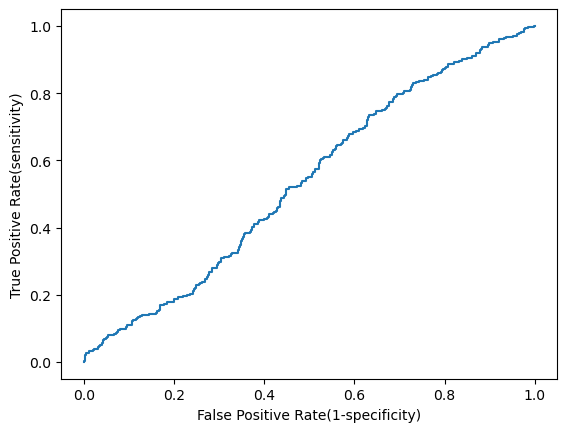

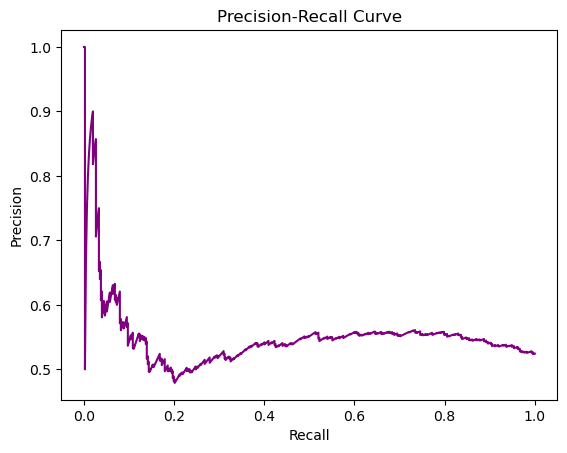

Score: 0.5569422776911076


In [28]:
#making the new model
e_trees = ExtraTreesClassifier(min_samples_leaf=2,min_samples_split=5, n_estimators=100 )
p1 = Pipeline([('Scaler', preprocess_transformer),('model',e_trees)])

#testing the new model
fit_and_print(p1,new_x_train_trees, y_train, new_x_test_trees, y_test)

The model looks like its overfitting, but i tried some more grid search parameters and it did not change much. There may be still some more room for improvement here. The model has 347 True positives and 105 False positives and that gives it a recall score of 0.77. It was right about 55% of the time for both directions and has a higher sensitivity, meaning it performs better on the positive side. 

# 8. XGBoost

XGBoost is a higly efficient model that is wideley known. It uses gradient boosting and combines a set of 'weak learners'(in our case descision trees). Every next tree prioritizes learning to solve the parts of the problem that the previous tree couldnt solve.

<img src = https://www.researchgate.net/publication/348025909/figure/fig2/AS:1020217916416002@1620250314481/Simplified-structure-of-XGBoost.ppm
svg.png width = "500" height = "500" align='left'>


I am doing the same things for the XGBoost model

In [29]:
feature_selector_xgb = make_feature_selector(x_train, y_train, xgb)

new_x_train_xgb = feature_selector_xgb.transform(x_train)
new_x_test_xgb = feature_selector_xgb.transform(x_test)

print(f"Selected features:")
print(features[feature_selector_xgb.support_])

Selected features:
['rsi6' 'rsi24' 'volume_change_3']


The XGBoost model only selected 3 features out of the 44. It too selected the rsi indicator for the 6 and 24 day period. 

Im going to be taking the same approach, but with a little less estimators, since the XGBoost model still overfits, but not to the extent of the ExtraTree. I'm also giving it the learning_rate parameter and optimizing it exponentially.

In [30]:
p2 = Pipeline([('Scaler', preprocess_transformer),('model',xgb)])

In [31]:
params = {'model__n_estimators':[70,100,200,300],
         'model__max_depth':[2,3,5,7],
          'model__learning_rate':[0.001,0.1,1]
         }

grid_search = GridSearchCV(estimator=p2, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_xgb, y_train)

grid_search.best_score_
grid_search.best_params_

{'model__learning_rate': 1, 'model__max_depth': 3, 'model__n_estimators': 200}

In [51]:
xgb = XGBClassifier(learning_rate=0.1,max_depth=5, n_estimators=100 )
p2 = Pipeline([('Scaler', preprocess_transformer),('model',xgb)])

Training score:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       917
           1       0.80      0.90      0.85      1096

    accuracy                           0.82      2013
   macro avg       0.83      0.82      0.82      2013
weighted avg       0.83      0.82      0.82      2013

Test score:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       411
           1       0.54      0.50      0.52       452

    accuracy                           0.51       863
   macro avg       0.51      0.51      0.51       863
weighted avg       0.51      0.51      0.51       863



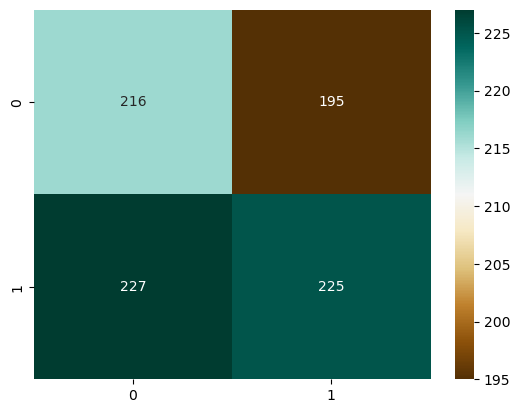

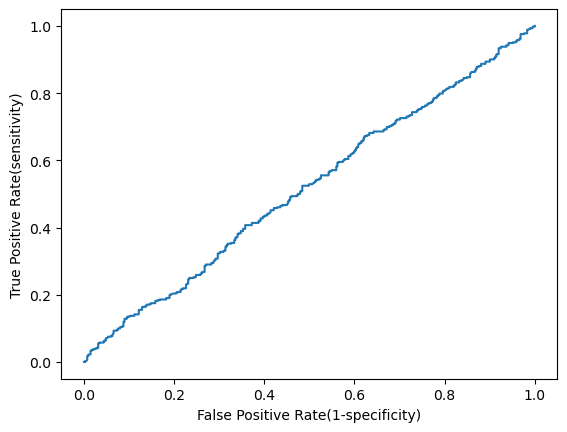

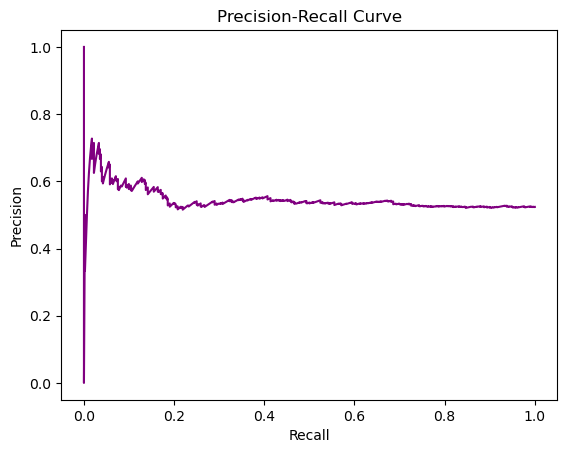

Score: 0.5357142857142857


In [52]:
fit_and_print(p2,new_x_train_xgb, y_train, new_x_test_xgb, y_test)

It looks like there is still some overfitting, although not as much as in the ExtraTrees model. There are 225 true positives and 227 true negatives which gives it a recall of 50%, it was right 54% of the time for the positive predictions and 49% of the time for the negative predictions. Since it has a f1 score of practically 51, the roc curve is pretty much flat and since it has a presicion and recall score of practically 50% it's presicion-recall curve is flat as well, exept for some interesting volatility in the extreme presicion cases.

# 9. Extra Tree

'An extremely randomized tree classifier.' - thats coming strainght from the sklearn documentation. It's essentially a descision tree, but when looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen.

<img src = https://www.researchgate.net/publication/346995264/figure/fig1/AS:969705405812741@1608207193473/The-structure-of-ExtraTree.png
svg.png width = "500" height = "500" align='left'>

Im doing the same thing for the Extra Tree model

In [34]:
feature_selector_e_tree = make_feature_selector(x_train, y_train, e_tree)

new_x_train_e_tree = feature_selector_e_tree.transform(x_train)
new_x_test_e_tree = feature_selector_e_tree.transform(x_test)

print(f"Selected features:")
print(features[feature_selector_e_tree.support_])

Selected features:
['sentiment' 'n_tweets' 'n_tweets_2' 'price_change_1' 'tweets_change_1'
 'volume_change_1' 'tweets_change_3' 'edit_count_change_3'
 'tweets_change_7' 'edit_count_change_7' 'volume_change_7']


The Extra Tree model selected the most amount of features(11 out of 44) and it chose not to use the rsi indicator as a feature. Its also the only model that selected some of the rolling and sentiment features.

In [35]:
p3 = Pipeline([('Scaler', preprocess_transformer),('model',e_tree)])

In [36]:
params = {'model__max_depth':[2,3,5,7,10],
         'model__min_samples_split':[2,3,5,7],
          'model__min_samples_leaf':[1,2,3,5],
          'model__splitter':['random','best']
         }


grid_search = GridSearchCV(estimator=p3, param_grid=params,scoring='precision',cv=tsp)
grid_search.fit(new_x_train_e_tree, y_train)

grid_search.best_params_

{'model__max_depth': 5,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 7,
 'model__splitter': 'best'}

In [53]:
e_tree = ExtraTreeClassifier(max_depth=5,min_samples_leaf=1,min_samples_split=7,splitter='best')
p3 = Pipeline([('Scaler', preprocess_transformer),('model',e_tree)])

Training score:
              precision    recall  f1-score   support

           0       0.68      0.25      0.37       917
           1       0.59      0.90      0.71      1096

    accuracy                           0.61      2013
   macro avg       0.64      0.58      0.54      2013
weighted avg       0.63      0.61      0.56      2013

Test score:
              precision    recall  f1-score   support

           0       0.50      0.10      0.17       411
           1       0.53      0.90      0.67       452

    accuracy                           0.52       863
   macro avg       0.51      0.50      0.42       863
weighted avg       0.51      0.52      0.43       863



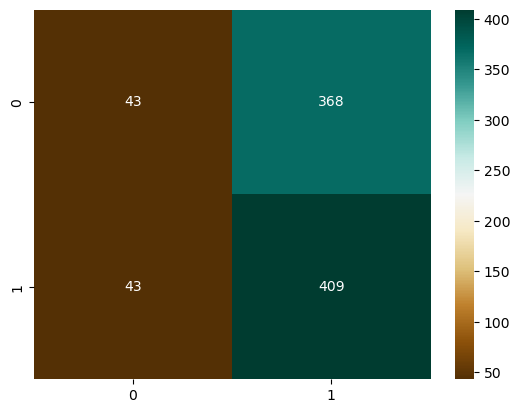

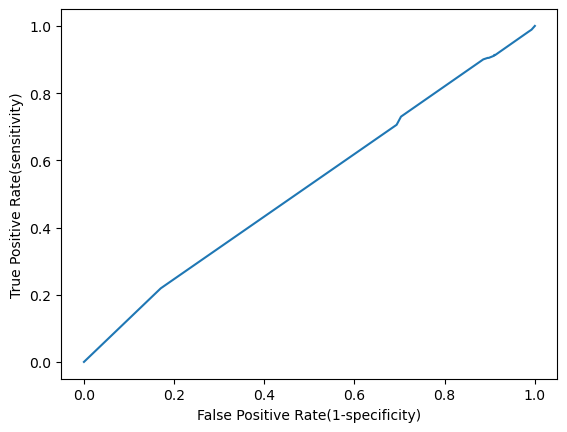

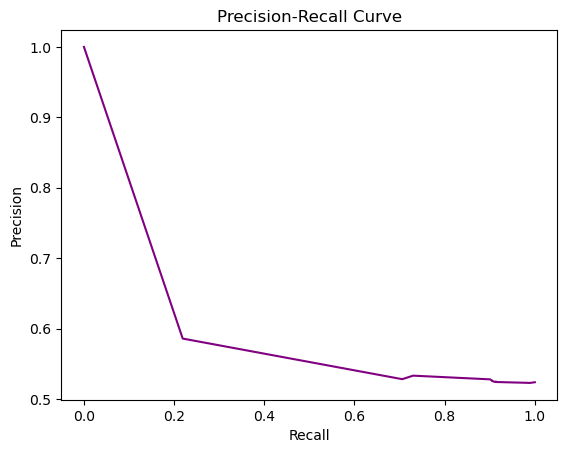

Score: 0.5263835263835264


In [54]:
fit_and_print(p3,new_x_train_e_tree, y_train, new_x_test_e_tree, y_test)

We can safely say that there is not much overfitting here. There are 409 true positives and 43 true negatives which gives it a pretty high recall of 90%, it was right 53% of the time for the positive predictions and 50% of the time for the negative predictions. It has a higher sensitivity, meaning it performs better on the positive side, we can see that in the recall and f1 score of the negative predictions.

# 10. Combining the models 

Now I'm going to be combining the predictions of all the models into one. The idea being that if one model is wrong, the other 2 can correct it. Im going to be implementing it by adding the predicted values of all the models and dividing the sum by 3. That way if 2 models vote for 1 and one for 0, the sum devided by 3 is 0.66, after we round it we're going to get 1, which is the majority vote of the three models.

In [39]:
#fitting the models and getting predictions
p1.fit(new_x_train_trees, y_train)
p1_preds = p1.predict(new_x_test_trees)

p2.fit(new_x_train_xgb, y_train)
p2_preds = p2.predict(new_x_test_xgb)

p3.fit(new_x_train_e_tree, y_train)
p3_preds = p3.predict(new_x_test_e_tree)

#making a dataframe
data = {'ExtraTrees':p1_preds,
        'XGBoost':p2_preds,
        'ExtraTree':p3_preds}
preds = pd.DataFrame(data,index=x_test.index)

#making a column for the combined predictions
preds['combined']=(preds['ExtraTrees']+preds['XGBoost']+preds['ExtraTree'])/3
preds['combined']=preds['combined'].astype(int)

In [40]:
#making a test function
def test(preds, real):
    
    print('Test score:')
    print(classification_report(real, preds))
    
    sns.heatmap(confusion_matrix(real, preds),annot=True, cmap='BrBG', fmt='g')
    plt.show()
    
    print('Benchmark for test data:',np.count_nonzero(real==1)/real.count())
    
    print('Final Score:',precision_score(real, preds))
    
    print('Performance:',precision_score(real,preds)-np.count_nonzero(real==1)/real.count())

Test score:
              precision    recall  f1-score   support

           0       0.49      0.73      0.59       411
           1       0.57      0.33      0.41       452

    accuracy                           0.52       863
   macro avg       0.53      0.53      0.50       863
weighted avg       0.53      0.52      0.50       863



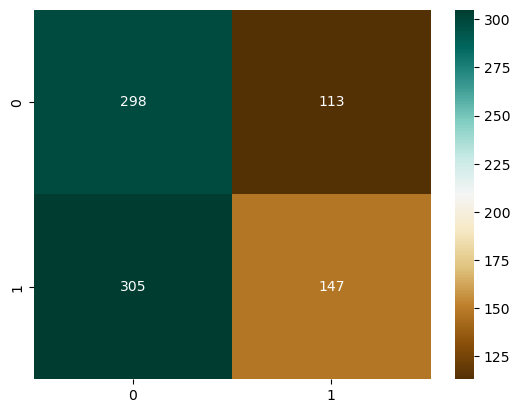

Benchmark for test data: 0.5237543453070683
Final Score: 0.5653846153846154
Performance: 0.04163027007754705


In [41]:
test(preds['combined'],y_test)

There are 147 true positives and 298 true negatives which gives our final model a recall score of 33%, it was right 57% of the time for the positive predictions, but only 49% of the time for the negative predictions. It has a much higher specificity, meaning it performs 'better' on the negative side, we can see that in the recall and f1 score of the negative predictions. The price wen up 52.4% of the time in our testing set, so if we were to buy in the begining of every day and sell at the end of every day, we would've been correct 52.4% of the time. The final model was right about 56.5% of the time, although it did make a lot less guesses that the price will go up.

# 11. Exploring the model
###### Now that we know that our model works, lets run some more specific tests and see where the model excels and lacks. I'm going to be performing 4 different tests to see where the model's strenghts and weaknesses are. The tests are going to be the following:  

Testing the model in a __Bull market__, where the price generally goes up and our benchmark score will be way higher.  

Testing the model in a __Bear market__, where the price generally goes down and there are less green days to predict.  

Testing the model in market conditions of __low volatility__ so we can see how well the model holds up when there are no major price moves and the price is consolidating.

Testing the model in market conditions with __high volatility__ so we can see how well the mdoel holds up when things get wild.

In order to perform the tests mentioned above, I'm going to be making a __mask__ for the above mentioned conditions and getting the predictions for that specific conditions via the __loc__ function.

Lets take a look at our test period and choose the adequate timeframes for the first two tests:

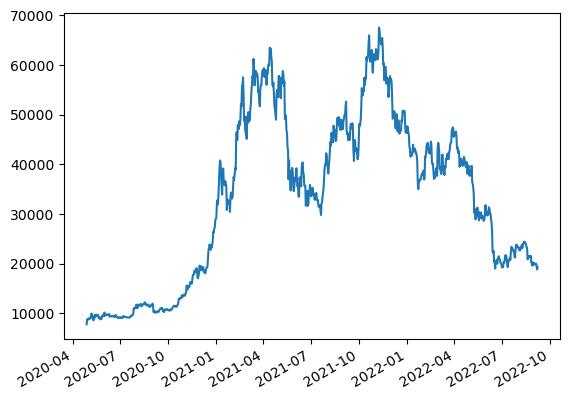

In [42]:
fig, ax = plt.subplots()
ax.plot(x_test.index, x_test.close)

fig.autofmt_xdate()
plt.show()

We can see that from the start of our test data up to 2021-04-14, Bitcon was in a huge Bull Market, and the price skyrocketed. It's a perfect timeframe to test the model in a bull run.  
For the Bear Market i decided to use the ATH of $69.420(nice) on 2021-11-11 as the starting point and the end point as the latest row.  

__Allright, lets start the testing__

Testing the model in a Bull Market:

Test score:
              precision    recall  f1-score   support

           0       0.43      0.69      0.53       148
           1       0.60      0.34      0.43       203

    accuracy                           0.49       351
   macro avg       0.52      0.51      0.48       351
weighted avg       0.53      0.49      0.47       351



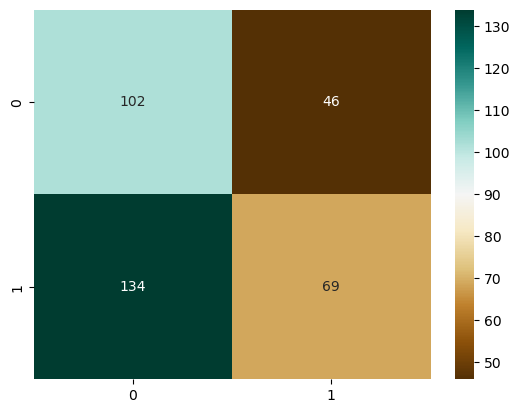

Benchmark for test data: 0.5783475783475783
Final Score: 0.6
Performance: 0.02165242165242165


In [43]:
#making a mask for the desired timeframe
mask_UT = (x_test.index > '2020-04-28') & (x_test.index <= '2021-04-14')

#fitting the test function to the data
test(preds['combined'].loc[mask_UT], y_test.loc[mask_UT])

Hmm... interesting. Although our model did get a higher presicion score, its performance compared to the market conditions dropped to just __2%__. Lets see how in compares to the performance in a Bear market.

Testing the model in a Bear Market:

Test score:
              precision    recall  f1-score   support

           0       0.56      0.74      0.63       157
           1       0.55      0.35      0.43       143

    accuracy                           0.55       300
   macro avg       0.55      0.54      0.53       300
weighted avg       0.55      0.55      0.54       300



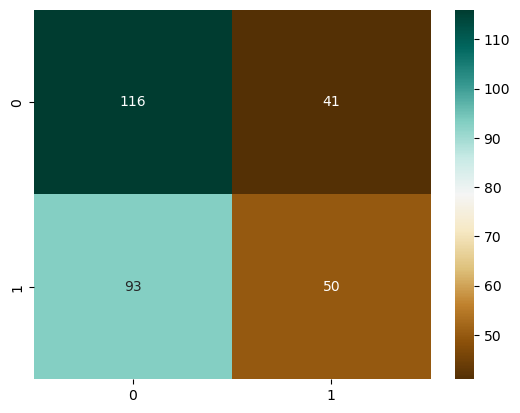

Benchmark for test data: 0.4766666666666667
Final Score: 0.5494505494505495
Performance: 0.07278388278388281


In [44]:
#making a mask for the desired timeframe
mask_DT = (x_test.index > '2021-11-11') 

#calling the test function
test(preds['combined'].loc[mask_DT], y_test.loc[mask_DT])

Wow... The model performed really good in the bear market and managed to get a __7%__ better score than the benchmark. Thats twice the baseline score of the model.  

Given these observations, we can conclude that the model has way more predictive power during the Bear Market than it does during the Bull Market(almost __5 times__ more).

Okay, we know how the model performs during Uptrends and Downtrends, but let's see how well it can predict the high vs low volatility market conditions. In order to mesure if a price move has a high or low volatility I'm going to be taking the __mean__ value of the absolute values of the __price_change_1__ column. If the absolute value of the __price_change_1__ column on a given day is __greater__ than the mean its considert a day with __high volatility__. If the value is __lower__ than the avarage, then its considered a day with __low volatility__.

Testing the days with high volatility:

Test score:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59       271
           1       0.54      0.32      0.40       284

    accuracy                           0.52       555
   macro avg       0.52      0.52      0.50       555
weighted avg       0.52      0.52      0.50       555



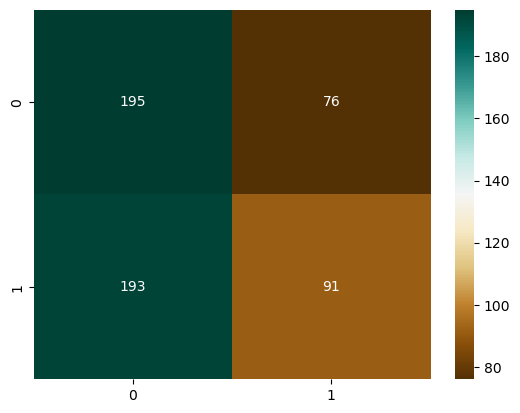

Benchmark for test data: 0.5117117117117117
Final Score: 0.5449101796407185
Performance: 0.033198467929006825


In [45]:
#making a mask for the days with low volatility
mask_LV = x_test.price_change_1.abs() <= x_test.price_change_1.abs().mean()

#making a dataframe for the data
low_vol_test = x_test.loc[mask_LV]
low_vol_test['preds'] = preds['combined']
low_vol_test['real'] = y_test

#calling the test function
test(low_vol_test.preds, low_vol_test.real)

Okay. The model underperformed a bit on the lower volatility data and got a 3.3% better score than the benchmark. This means that the model is still pretty robust in periods of consolidation and low volatility days. Now lets check how it does when things get a little wild.

Testing the model on data with high volatility:

Test score:
              precision    recall  f1-score   support

           0       0.48      0.74      0.58       140
           1       0.60      0.33      0.43       168

    accuracy                           0.52       308
   macro avg       0.54      0.53      0.50       308
weighted avg       0.55      0.52      0.50       308



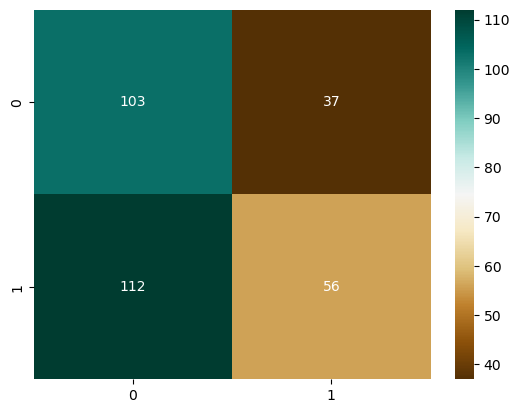

Benchmark for test data: 0.5454545454545454
Final Score: 0.6021505376344086
Performance: 0.05669599217986321


In [46]:
#making a mask for the days with high volatility
mask_HV = x_test.price_change_1.abs() >= x_test.price_change_1.abs().mean()

#constructing a dataset for the days with high volatility
high_vol_test = x_test.loc[mask_HV]
high_vol_test['preds'] = preds['combined']
high_vol_test['real'] = y_test

#callong the test function
test(high_vol_test.preds, high_vol_test.real)

Nice... The model managed to get a presicion score of 60% on the days with high volatility with a benchmark of 54.5%. That gives it a performance score of 6% on the days with high volatility, which is really good, since the days with more volatility bring more returns(and risk) than those with lower levels of volatility, so its really important that the model is robust when it comes to periods of high volatility.  

Let's compare the results:

In [47]:
#printing the performance score of all the tests
print('Performance Baseline:',precision_score(y_test,preds['combined'])-np.count_nonzero(y_test==1)/y_test.count())
print('Performance on Uptrend:',precision_score(y_test.loc[mask_UT],preds['combined'].loc[mask_UT])-np.count_nonzero(y_test.loc[mask_UT]==1)/y_test.loc[mask_UT].count())
print('Performance on Downtrend:',precision_score(y_test.loc[mask_DT],preds['combined'].loc[mask_DT])-np.count_nonzero(y_test.loc[mask_DT]==1)/y_test.loc[mask_DT].count())
print('Performance on High Volatility:',precision_score(low_vol_test.real,low_vol_test.preds)-np.count_nonzero(low_vol_test.real==1)/low_vol_test.real.count())
print('Performance on Low Volatility:',precision_score(high_vol_test.real,high_vol_test.preds)-np.count_nonzero(high_vol_test.real==1)/high_vol_test.real.count())

Performance Baseline: 0.04163027007754705
Performance on Uptrend: 0.02165242165242165
Performance on Downtrend: 0.07278388278388281
Performance on High Volatility: 0.033198467929006825
Performance on Low Volatility: 0.05669599217986321


Wow... The results definately surprised me.  
We can see that the model really underperformend on Bull Markets and really exceled on Bear Markets with a pretty big differance as well. There is still more research to be done here as to why the difference here is so big. Maybe there are more unpredictable events on bull markets, since there is greater interest in Bitcoin, for example: a big company saying publicly that they hold Bitcoin. Like i said, there is still more research to be done here, thats just my thesis. The model did not change as much based on the volatility of the data, and it even outperformed on the higher volatility data.

I think this model is about as much as we can squieze out of a normal ML model. If we want a better score then we shoud get a lot more data and/or build a more complex model(Neural Network). All and all I'm pretty happy with the performance of the model, since it __is__ better than randomly guessing, which was the main goal of this project. I guess the financial markets arent __all__ random noise huh... .

# 12. Further Improvements

1) Better Voting system - sklearn's VotingClassifier for example.

2) More data - there is still a lot of room for more data such as on chain data like hashrate and maybe even some sentiment analysis on CNBC news articles.

3) Implementing a more complex model or even a Deep Learning model.

# 13. Rescources:
1) DataQuest: https://www.youtube.com/watch?v=TF2Nx_ifmrU (his model managed to only get 53.6% precision, so im really happy with the performance of my model)

2) Divta Yageti's Medium Blog: https://medium.com/coinmonks/forecasting-next-day-btc-prices-using-a-high-dimensional-multivariate-data-cb833ab61183 (gave me the idea for the web scraping of the twitter data)

3) Analyticssteps's blog https://www.analyticssteps.com/blogs/introduction-time-series-analysis-time-series-forecasting-machine-learning-methods-models (research)

4) Aden Aurelius's Medium blog https://towardsdatascience.com/things-that-you-should-check-before-creating-univariate-time-series-model-ba5fe381f68e (research)